<a href="https://colab.research.google.com/github/vasilievan/telecom_labs/blob/main/Vasiliev_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate
import thinkplot
if not os.path.exists('thinkplot.py'):
  !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py

## Упражнение 2

Из примеров кода chap05.ipynb показано как использовать автокорреляцию для оценки основ-
ной частоты периодического сигнала. Инкапсулируем код в функцию estimate_fundamental
и используем ее для отслеживания высоты тона записанного звука. Для теста возьмем звук
саксофона.

In [ ]:
if not os.path.exists('447951__nowherestudios__saxophone-2-tenor-unprocessed.wav'):
    !wget https://github.com/vasilievan/telecom_labs/raw/main/447951__nowherestudios__saxophone-2-tenor-unprocessed.wav

In [ ]:
from thinkdsp import read_wave

wave = read_wave('447951__nowherestudios__saxophone-2-tenor-unprocessed.wav')
wave.normalize()
wave.make_audio()

Спекртограма:

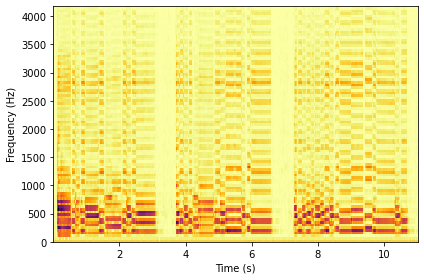

In [ ]:
wave.make_spectrogram(2048).plot(high=4200)
decorate(xlabel='Time (s)', 
         ylabel='Frequency (Hz)')

Функция estimate_fundamental из главы 5 Самый высоки пик в функции автокорреляции
был отслежен с помощью выставления диапозана лагов для поиска от 70 до 150.

In [ ]:
def estimate_fundamental(segment, low=70, high=150):
    lags, corrs = autocorr(segment)
    lag = np.array(corrs[low:high]).argmax() + low
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

In [ ]:
def autocorr(wave):
    lags = np.arange(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

In [ ]:
def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr_mat = np.corrcoef(y1, y2)
    return corr_mat[0, 1]

In [ ]:
duration = 0.01
segment = wave.segment(start=0.2, duration=duration)
freq = estimate_fundamental(segment)
freq

644.2953020134229

In [ ]:
step = 0.05
starts = np.arange(0.0, 1.4, step)

ts = []
freqs = []

for start in starts:
    ts.append(start + step/2)
    segment = wave.segment(start=start, duration=duration)
    freq = estimate_fundamental(segment)
    freqs.append(freq)

Зеленая линия на графике показвыает отслеживание высоты тона, она наложена на спектро-
граму.

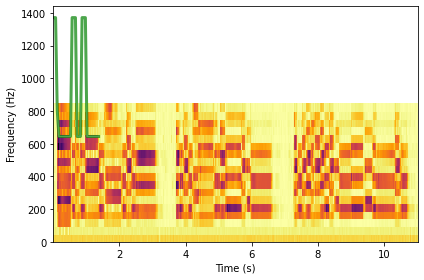

In [ ]:
wave.make_spectrogram(2048).plot(high=900)
plt.plot(ts, freqs, color='white')
decorate(xlabel='Time (s)', 
                     ylabel='Frequency (Hz)')
thinkplot.plot(ts, freqs, color='green')


## Упражнение 3

Возьмем исторические данные BitCoin за прошедшие полгода из прошлой лабораторной ра-
боты. Для этих данных вычислим автокорреляцию цен.

In [ ]:
if not os.path.exists('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv

--2022-04-10 13:12:05--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv [following]
--2022-04-10 13:12:05--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143622 (140K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 140.26K  --.-KB/s    in 0.02

In [ ]:
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2020-03-26-CoinDesk.csv', 
                 parse_dates=[0])

ys = df['Closing Price (USD)']
ts = df.index

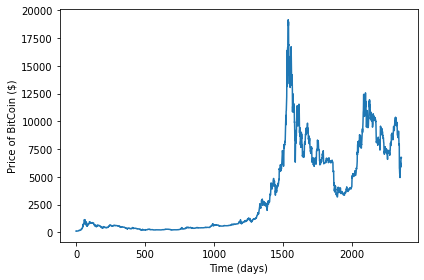

In [ ]:
from thinkdsp import Wave

wave = Wave(ys, ts, framerate=1)
wave.plot()
decorate(xlabel='Time (days)',
         ylabel='Price of BitCoin ($)')

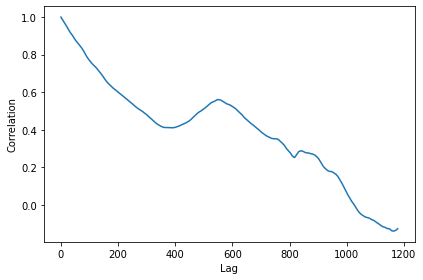

In [ ]:
lags, corrs = autocorr(wave)
plt.plot(lags, corrs)
decorate(xlabel='Lag',
         ylabel='Correlation')

График медлено снажается, похож на розовый шум. Есть умеренная корреляция на 55 дне.
Теперь вычислим корреляцию на основе функции np.correlate. Она не смещает и не нормализует волну.

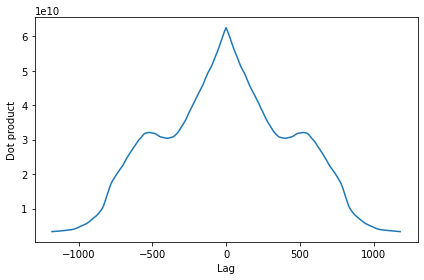

In [ ]:
N = len(wave)
corrs2 = np.correlate(wave.ys, wave.ys, mode='same')
lags = np.arange(-N//2, N//2)
plt.plot(lags, corrs2)
decorate(xlabel='Lag',
         ylabel='Dot product')

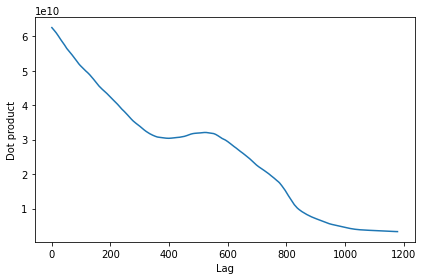

In [ ]:
N = len(corrs2)
half = corrs2[N//2:]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

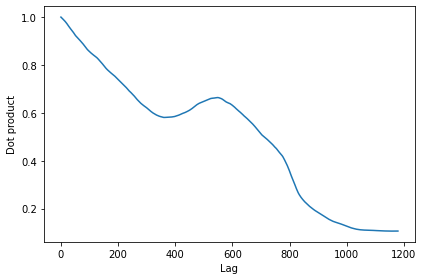

In [ ]:
lengths = range(N, N//2, -1)
half /= lengths
half /= half[0]
plt.plot(half)
decorate(xlabel='Lag',
         ylabel='Dot product')

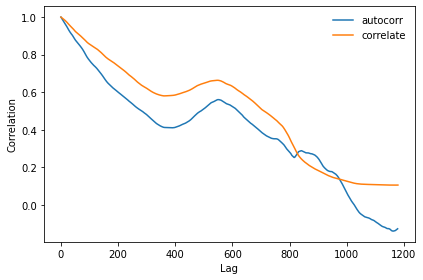

In [ ]:
plt.plot(corrs, label='autocorr')
plt.plot(half, label='correlate')
decorate(xlabel='Lag', ylabel='Correlation')

## Упражнение 3

In [ ]:
if not os.path.exists('28042__bcjordan__voicedownbew.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/28042__bcjordan__voicedownbew.wav